## Builing a graph

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

### Example No1 (Figure 3)

In [173]:
L = ['T']
N = ['A', 'Y', 'M', 'T', 'F']

G = nx.DiGraph()
G.add_edges_from([('A', 'M'),
                  ('T', 'A'),
                  ('T', 'F'),
                  ('F', 'A'),
                  ('U', 'F'),
                  ('U', 'Y'),
                  ('M', 'Y')])

### Example No2 (Figure 4)

In [177]:
L = ['T']
N = ['A', 'Y', 'T', 'W1', 'W2', 'W3', 'W4']

G = nx.DiGraph()
G.add_edges_from([('A', 'Y'),
                  ('T', 'W1'),
                  ('T', 'Y'),
                  ('W1', 'A'),
                  ('W2', 'W1'),
                  ('W2', 'Y'),
                  ('W3', 'W1'),
                  ('W3', 'Y'),
                  ('W4', 'Y')])

### Example No4 (Figure 5)

In [153]:
L = []
N = ['A', 'Y', 'Z1', 'Z2']

G = nx.DiGraph()
G.add_edges_from([('A', 'Y'),
                  ('Z1', 'A'),
                  ('Z1', 'Z2'),
                  ('U', 'Z2'),
                  ('U', 'Y')])

## Auxiliar Functions

In [3]:
def ancestors_all (G, nodes):
    
    res = set()
    
    for node in nodes:
        ancestors_node = nx.ancestors(G, node)
        res = res.union(ancestors_node)

    # we also include the same nodes as its own ancestors
    res = res.union(set(nodes))
        
    return list(res)


def back_door (G):
    
    G2 = G.copy()
    
    for path in nx.all_simple_edge_paths(G, 'A', 'Y'):
        first_edge = path[0]
        G2.remove_edge(first_edge[0], first_edge[1])
    
    return G2

def causal_vertices (G):
    """
    Given a graph with two vertices A and Y, it returns the set of all vertirtices that 
    lie in a causal path between A and Y, except by A.
    """
    
    vertices = set()
    
    causal_paths = list(nx.all_simple_paths(G, source = 'A', target = 'Y'))
    
    for path in causal_paths:
        
        vertices = vertices.union(set(path))
    
    vertices.remove('A')
    
    return vertices
    

def forbidden(G):
    
    res = set()
        
    for vertice in causal_vertices(G):
        
        res = res.union( nx.descendants(G, vertice).union(vertice) )
        
    return res.union('A')
    

def ignore (G, L, N):
    
    set1 = set(ancestors_all(G, L + ['A', 'Y']))
    set1.remove('A')
    set1.remove('Y')
    
    set2 = set(G.nodes()) - set(N)
    set2 = set2.union(forbidden(G))
     
    return set1.intersection(set2)


def unblocked (G, Z):
    
    G2 = G.subgraph( G.nodes() - set(Z) )
    
    B = nx.node_connected_component(G2, 'A')
    
    return nx.node_boundary(G, B)

In [77]:
def build_H0 (G, L, N):
        
    # restriction to ancestors
    anc = ancestors_all(G, L + ['A', 'Y'] )
    G2 = G.subgraph(anc)
    
    # proper back-door graph 
    G3 = back_door(G2)
    
    # moralization
    G4 = nx.moral_graph(G3)
    
    return G4

In [56]:
def build_H1 (G, L, N):
    
    H0 = build_H0(G, L, N)
    
    ignore_nodes = ignore(G, L, N)
    
    H1 = H0.copy().subgraph( H0.nodes() - ignore_nodes )
    H1 = nx.Graph(H1)
    
    
    """
    There are many ways to check if two nodes in H1 are connected by a path of nodes in ignore.
    The simplest one is to check for all paths and try to identify one path with all its nodes in ignore or {A, Y}
    
    A more efficient way to do this is to find the connectec components of H0.subgraph(ignore) and connect 
    all the nodes that are adyacent to the same connected component. 
    """
    
    vertices_list = list(H1.nodes())

    for i, node1 in enumerate(vertices_list):
        
        for node2 in vertices_list[(i+1):]:
            
            for path in nx.all_simple_paths(H0, source = node1, target = node2):
                
                if set(path).issubset( ignore_nodes.union(set([node1, node2])) ):
                
                    H1.add_edge(node1, node2)
                    break
    
    for node in L:
        
        H1.add_edge('A', node)
        H1.add_edge(node, 'Y')
    
    
    return H1

In [119]:
H0 = build_H0 (G, L, N)
H1 = build_H1 (G, L, N)

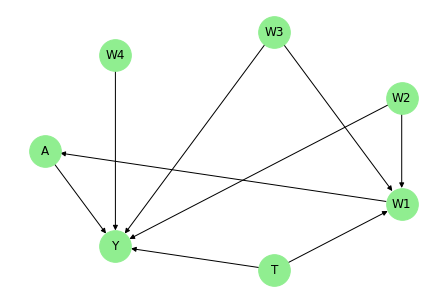

In [120]:
nx.draw_shell(G, with_labels=True, node_color='lightgreen', node_size = 1000)

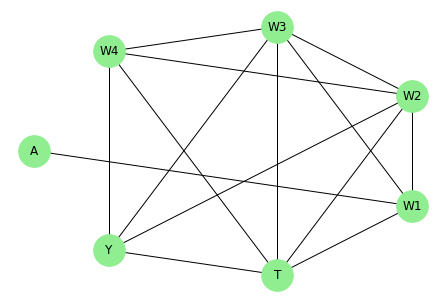

In [121]:
nx.draw_shell(H0, with_labels=True, node_color='lightgreen', node_size = 1000)

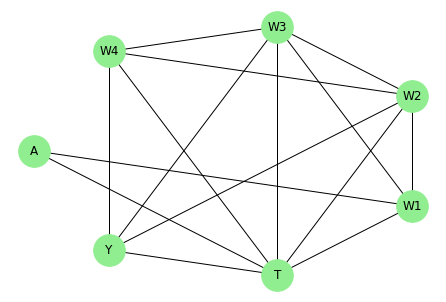

In [122]:
nx.draw_shell(H1, with_labels=True, node_color='lightgreen', node_size = 1000)

In [169]:
def optimal_adj_set (G, L, N): 
    
    H1 = build_H1(G, L, N)
    
    if N == G.nodes() or set(N).issubset( ancestors_all(G, L + ['A', 'Y'] ) ):
    
        return nx.node_boundary(H1, 'Y')
    
    else:
        
        return "there is no optimal adjustment set"


In [111]:
def minimal_adj_set (G, L, N):
    
    H1 = build_H1(G, L, N)
    
    return unblocked(H1, nx.node_boundary(H1, set(['Y'])))

In [132]:
def isInMinimum (G, node):
    
    m1 = len(nx.minimum_node_cut(G, 'A', 'Y'))
    
    G2 = G.copy()
    G2.add_edge('A', node)
    G2.add_edge('Y', node)
    
    m2 = len(nx.minimum_node_cut(G2, 'A', 'Y'))
    
    if m1 == m2:
        return True
    else:
        return False

In [166]:
def minimum_adj_set(G, L, N):
    
    H1 = build_H1(G, L, N)

    res = set()
    
    if not 'Y' in nx.node_connected_component(H1, 'A'):
        return res
    
    for path in nx.node_disjoint_paths(H1, s = 'Y', t = 'A'):

        for node in path:

            if node == 'Y':
                continue

            if isInMinimum(H1, node):

                res.add(node)
                break
                
    return res

### Results

In [178]:
optimal_adj_set(G, L, N)

{'T', 'W2', 'W3', 'W4'}

In [179]:
minimal_adj_set(G, L, N)

{'T', 'W2', 'W3'}

In [180]:
minimum_adj_set(G, L, N)

{'T', 'W1'}